### Tutorial to set up files for Routing software using stony brook watershed
1. Explore Domain
2. Explore Runoff Files
3. Explore Parameters
4. Build Network file
5. Plot the routed streamflow

#### 1. Exploring the domain

Use this section to visualize what is being utilized as underlying hydrography for routing.

In [2]:
import geopandas as gpd

In [3]:
streams = gpd.read_file('./hydrography/links.gpkg')
hillslopes = gpd.read_file('./hydrography/hillslopes.gpkg')

# Plot both layers together
m = hillslopes.explore(
        color='red',
        fill=False,
        alpha=1,
        name='Hillslopes'
    )
m = streams.explore(
    m=m,
    color='blue',
    tooltip='stream',
    name='Streams'
)
m

#### 2. Explore the Runoff files

It is recommended to use Xarray to examine the structure of the input runoff NetCDF files. Examine the 'ro' variable structure. 

In [4]:
import xarray as xr

In [5]:
xr.open_dataset('./runoff/total_runoff_2017.nc')

<xarray.Dataset> Size: 28MB
Dimensions:     (valid_time: 8760, LinkID: 786)
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 70kB 2017-01-01 ... 2017-12-31T23...
  * LinkID      (LinkID) int64 6kB 420558772 420557886 ... 420542940 420543561
Data variables:
    ro          (LinkID, valid_time) float32 28MB ...

In [6]:
xr.open_dataset('./runoff/total_runoff_2018.nc')

<xarray.Dataset> Size: 28MB
Dimensions:     (valid_time: 8760, LinkID: 786)
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 70kB 2018-01-01 ... 2018-12-31T23...
  * LinkID      (LinkID) int64 6kB 420558772 420557886 ... 420542940 420543561
Data variables:
    ro          (LinkID, valid_time) float32 28MB ...

#### 3. Explore the Parameters

The following parameters are what are used for the example. 

In [7]:
import pandas as pd

In [8]:
df = pd.read_csv('./hydrography/params_table.csv')
df.head()

,stream,next_stream,drainage_area_km2,length_km,area_sqkm,centroid_lon,centroid_lat,l1,vo
0,420558772,420558773,0.112,0.330,0.112,-74.790662,40.311691,0.435205,1.669654
1,420557886,420558773,0.086,0.210,0.086,-74.788429,40.314519,0.434928,1.719903
2,420553620,420553417,0.761,1.358,0.761,-74.796961,40.329662,0.448282,1.151088
3,420553824,420553417,0.053,0.117,0.053,-74.789896,40.330208,0.439468,1.733405
4,420553417,420551946,0.841,0.234,0.027,-74.790625,40.333125,0.452910,1.144380


#### 4. Generate the network and parameters file with NetworkX

Note: This is the same code provided in the parameters section of the wiki page. 

In [1]:
import networkx as nx
import pandas as pd

4.1 Set up the dataframe in correct units

In [2]:
df = pd.read_csv('./hydrography/params_table.csv')
df['A_h'] = df['area_sqkm']*(10**6) #Hillslope area in sq. meters
df['L'] = df['length_km']*(1000) #Length in meters
df['lambda_1'] = df['l1'].round(2)
df['v_0'] = df['vo'].round(2)
df["params"] = df[["A_h", "L", "lambda_1", "v_0"]].astype(str).agg(";".join, axis=1)

4.2 Define helper to compute stream levels

In [3]:
def compute_levels(G):
    levels = {}
    for node in nx.topological_sort(G):
        preds = list(G.predecessors(node))
        if preds:
            levels[node] = max(levels[p] for p in preds) + 1
        else:
            levels[node] = 0
    return levels

4.3 Build the directed stream network

In [4]:
# Create directed graph
G = nx.DiGraph()
streams_set = set(df['stream']) # ensure not including next streams that are clipped
# Add edges where next_stream is not -1
for _, row in df.iterrows():
    src = row['stream']
    dst = row['next_stream']
    if dst != -1 and dst in streams_set:
        G.add_edge(src, dst)

# Add all streams as nodes in case some are disconnected (e.g., with next_stream = -1)
for stream in df['stream'].unique():
    G.add_node(stream)

4.4 Compute topological order, levels, and upstream connections

In [5]:
# Get topological order
topo_order = list(nx.topological_sort(G))
node_to_index = {node: i for i, node in enumerate(topo_order)}

# Build upstream map
predecessors = {
    node: [node_to_index[p] for p in G.predecessors(node)]
    for node in topo_order
}

levels = compute_levels(G)

4.5 Create the parameters file

In [6]:
rows = []
for node in topo_order:
    idx = node_to_index[node]
    level = levels[node]
    parents = predecessors.get(node, [])
    params = df['params'][df['stream']==node].values[0]
    row = {
        "index": idx,
        "node": node,
        "level": level,
        "parents": ";".join(map(str, parents)) if parents else "",
        "params": params
    }
    rows.append(row)

df_out = pd.DataFrame(rows)
df_out = df_out.astype({"index": "int32", "node": "int32", "level": "int32"})
# df_out.to_csv("params.csv", index=False)
df_out.head(10)

,index,node,level,parents,params
0,0,420558772,0,,112000.0;330.0;0.44;1.67
1,1,420557886,0,,86000.0;210.0;0.43;1.72
2,2,420553620,0,,761000.0;1358.0;0.45;1.15
3,3,420553824,0,,53000.0;117.0;0.44;1.73
4,4,420552578,0,,230000.0;517.0;0.44;1.44
5,5,420550311,0,,151000.0;419.0;0.44;1.49
6,6,420550722,0,,112000.0;375.0;0.44;1.62
7,7,420550310,0,,112000.0;304.0;0.44;1.62
8,8,420549714,0,,92000.0;210.0;0.44;1.68
9,9,420548919,0,,79000.0;234.0;0.45;1.64


In [7]:
parents

[515, 784]

#### 5. Plot the outputs

In [1]:
import xarray as xr
import nc_time_axis

In [6]:
flow = xr.open_dataset('../../../Tiger_HLM_Routing/data/outputs/mytimeseries_2017-01-01_00_00_00.nc')
flow

<xarray.Dataset> Size: 13MB
Dimensions:  (LinkID: 383, time: 8760)
Coordinates:
  * LinkID   (LinkID) int32 2kB 420557052 420556226 ... 420543969 420543767
  * time     (time) object 70kB 2017-01-01 00:00:00 ... 2017-12-31 23:00:00
Data variables:
    outputs  (time, LinkID) float32 13MB ...

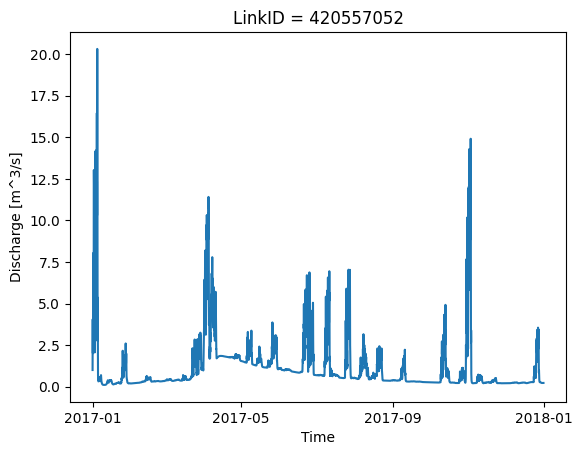

In [7]:
flow.sel(LinkID=420557052).outputs.plot()

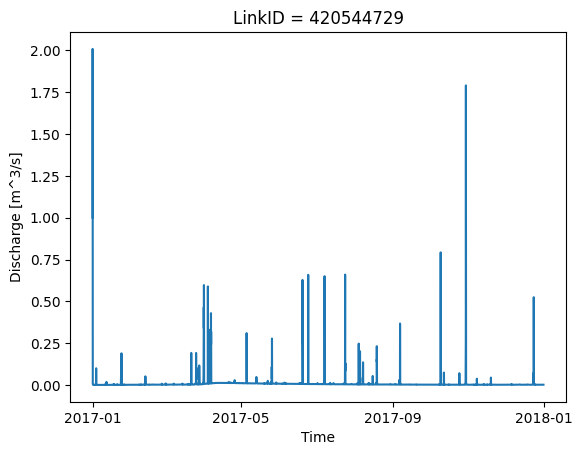

In [9]:
flow.sel(LinkID=420544729).outputs.plot()